SVM Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.41      0.51        34
        True       0.66      0.84      0.74        45

    accuracy                           0.66        79
   macro avg       0.66      0.63      0.62        79
weighted avg       0.66      0.66      0.64        79

Random Forest Classification Report:
               precision    recall  f1-score   support

       False       0.59      0.47      0.52        34
        True       0.65      0.76      0.70        45

    accuracy                           0.63        79
   macro avg       0.62      0.61      0.61        79
weighted avg       0.63      0.63      0.63        79

Selected features by MRMR: ['Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']


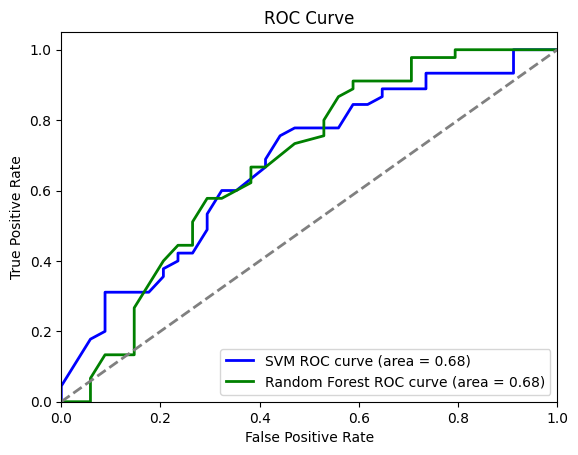

In [ ]:
# Install necessary packages
!pip install pandas networkx pymrmr scikit-learn matplotlib

# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import pymrmr

# Load the CSV file
file_path = '151string.csv.csv'  # Update this with the correct path to your file
df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Correct column names based on your inspection
df.columns = ['#node1', 'node2', 'node1_string_id', 'node2_string_id',
              'neighborhood_on_chromosome', 'gene_fusion', 'phylogenetic_cooccurrence',
              'homology', 'coexpression', 'experimentally_determined_interaction',
              'database_annotated', 'automated_textmining', 'combined_score']

# Construct the graph
G = nx.from_pandas_edgelist(df, '#node1', 'node2', edge_attr=True)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Combine centrality measures into a DataFrame
centrality_df = pd.DataFrame({
    'Node': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values())
})

# Add combined score from the original dataframe to the centrality_df
centrality_df = centrality_df.merge(df[['#node1', 'combined_score']].drop_duplicates(), left_on='Node', right_on='#node1', how='left')
centrality_df.drop(columns='#node1', inplace=True)

# Create a binary target variable
centrality_df['Hub'] = centrality_df['combined_score'] > 0.95

# Define features and target
features = centrality_df[['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']]
target = centrality_df['Hub']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate SVM
svm_predictions = svm_model.predict(X_test_scaled)
svm_probabilities = svm_model.predict_proba(X_test_scaled)[:, 1]
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Prepare data for MRMR
centrality_df['Hub'] = centrality_df['Hub'].astype(int)  # Convert boolean to int
centrality_df_mrmr = centrality_df.drop(columns=['Node', 'combined_score'])

# Apply MRMR
selected_features = pymrmr.mRMR(centrality_df_mrmr, 'MIQ', 3)
print("Selected features by MRMR:", selected_features)


# Calculate ROC curve and AUC score for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probabilities)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Calculate ROC curve and AUC score for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
